In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from google.colab import files

#from oauth2client.client import GoogleCredentials
#import getpass
#from google.colab import drive

#import zipfile

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerLine2D

Using TensorFlow backend.


**LOAD DATA**

Load data through google drive link

1289 photo images
1000 simulation images

In [0]:
def setData():
  !mkdir data/

  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1HzZBLsKi99RokCF-qLQeA9--L7XnVP5B' -O data/train.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1lNA-qSblcCX6wZEaQsJRp4ImuCOWCXe0' -O data/addsucc.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1sGdu1OMsB5WPaVf5QxL0D3BPkpM6hOYJ' -O data/addon_desk.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=16TyVfg-CWPLr8wIA8VfzgAwWspvF2RIk' -O data/simsucc.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1MRG2JlDXaRgsXnGGr5wYfcKDJJnxzFR5' -O data/sim_on_desk.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1IpaIM1K0cdeQTk_m_lLirjbVGZJTHRVA' -O data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  !mkdir data/train
  !unzip data/train.zip -d data/train/
  !unzip data/addsucc.zip -d data/train/train/succ/
  !unzip data/addon_desk.zip -d data/train/train/zon_desk/
  !unzip data/simsucc.zip -d data/train/train/succ/
  !unzip data/sim_on_desk.zip -d data/train/train/zon_desk/


Load weights from pre trained model(Inception_v3).

In [0]:

def loadWeight(pixels):

  local_weights_file = r'data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

  pre_trained_model = InceptionV3(
      input_shape=(pixels, pixels, 3), include_top=False, weights=None)
  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False
  
  last_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape:', last_layer.output_shape)
  last_output = last_layer.output

  return last_output, pre_trained_model

Add layer to the pre trained model


In [0]:
def configureLayers(last_output, pre_trained_model):

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(pre_trained_model.input, x)
  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])
  return model

**Image Processing**

Transform image to the given size array.

Add data-augmentation. Augmented data will be applied randomly in each epoch.

In [0]:
def imgGenerator(trainpath, validpath, pixels):
  train_dir = trainpath
  valid_dir=validpath

  train_datagens=[]

  val_datagen = ImageDataGenerator(rescale=1./255)
  train_datagens.append(val_datagen)

  # Add data-augmentation parameters to ImageDataGenerator
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


  train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(pixels,pixels),
      batch_size=20,
      class_mode='binary')

  valid_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(pixels, pixels),  
        batch_size=20,
        class_mode='binary')
  
  return train_generator, valid_generator


**Train Model**

Train model and draw a graph for accuracy and validation

In [0]:
def trainGraph(model, train_generator, valid_generator):
  history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=30,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        verbose=2)



# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
  acc = history.history['acc']
  val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

# Get number of epochs
  epochs = range(len(acc))

# Plot training and validation accuracy per epoch
  train1,=plt.plot(epochs, acc)
  valid1, =plt.plot(epochs, val_acc)
  plt.title('Training and validation accuracy')

  plt.legend([(train1),(valid1)],['train','valid'])


  plt.figure()

# Plot training and validation loss per epoch
  train2,=plt.plot(epochs, loss)
  valid2,=plt.plot(epochs, val_loss)
  plt.title('Training and validation loss')

  plt.legend([(train2),(valid2)],['train','valid'])

In [0]:
setData()

In [0]:
last_output, pre_trained_model=loadWeight(450)

last layer output shape: (None, 26, 26, 768)


In [0]:
model= configureLayers(last_output, pre_trained_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
train_generator, valid_generator=imgGenerator('data/train/train','data/train/valid',450)

Found 2289 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Epoch 1/30
Epoch 1/30
115/115 - 232s - loss: 1.1849 - acc: 0.6509 - val_loss: 0.3148 - val_acc: 0.8700
Epoch 2/30
Epoch 1/30
115/115 - 217s - loss: 0.5356 - acc: 0.7003 - val_loss: 0.2904 - val_acc: 0.8620
Epoch 3/30
Epoch 1/30
115/115 - 216s - loss: 0.4903 - acc: 0.7388 - val_loss: 0.2058 - val_acc: 0.8900
Epoch 4/30
Epoch 1/30
115/115 - 218s - loss: 0.4686 - acc: 0.7549 - val_loss: 0.5673 - val_acc: 0.7840
Epoch 5/30
Epoch 1/30
115/115 - 208s - loss: 0.4670 - acc: 0.7584 - val_loss: 0.1515 - val_acc: 0.9120
Epoch 6/30
Epoch 1/30
115/115 - 210s - loss: 0.4309 - acc: 0.7855 - val_loss: 0.1824 - val_acc: 0.9060
Epoch 7/30
Epoch 1/30
115/115 - 210s - loss: 0.4417 - acc: 0.7610 - val_loss: 0.3170 - val_acc: 0.8700
Epoch 8/30
Epoch 1/30
115/115 - 209s - loss: 0.4208 - acc: 0.7938 - val_loss: 0.2852 - val_acc: 0.8600
Epoch 9/30
Epoch 1/30
115/115 - 208s - loss: 0.4210 - acc: 0.7986 - val_loss: 0.5650 - val_acc: 0.8280
Epoch 10/30
Epoch 1/30
115/115 - 209s - loss: 0.3999 - acc: 0.8034 - val_

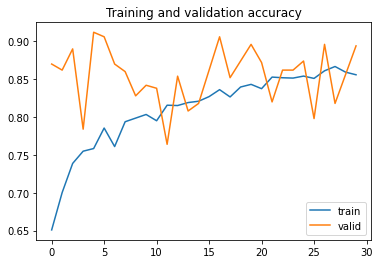

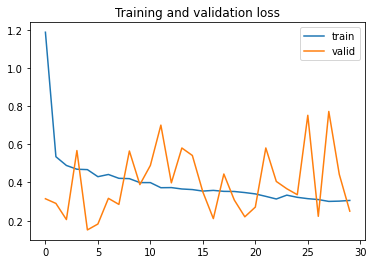

In [0]:
trainGraph(model,train_generator,valid_generator)

In [0]:
#display augmented images
def displayAug():
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True,
     fill_mode='nearest')
  
  img=load_img('data/train/train/succ/object_0_soccerball_grasp_0_lift389.png')
  x=img_to_array(img)
  x = x.reshape((1,) + x.shape)
  
 
  i = 0
  for batch in train_datagen.flow(x, batch_size=1, save_to_dir='augpics', save_format='png'):
    i += 1
    if i > 20:
      break

  aa=!ls augpics/
  paths=[]
  for s in aa:
    t=s.split(' ')
    for k in t:
      if k!='' and k!='\t':
        tmp='augpics/'+k
        paths.append(tmp)

  print(paths)
  nrows =5
  ncols =4

  pic_index=0

  fig=plt.gcf()
  fig.set_size_inches(ncols*4, nrows*4)

  pic_index+= 8

  i=0
  for img_path in paths:
    if i>19:
      break
    sp=plt.subplot(nrows,ncols, i+1)
    sp.axis('Off')

    img=mpimg.imread(img_path)
    plt.imshow(img)
    i+=1

  plt.show()
